## Final Project Submission

Please fill out:
* Student name: Crystal Dugan
* Student pace: self-paced 
* Scheduled project review date/time: 05-21-19 7:30pm EST
* Instructor name: Eli Thomas
* Blog post URL:


#### My Approach  
My goal was to model the King County Housing dataset with a multivariate linear regression in order to predict the sale price of houses as accurately as possible. First I put the data in a pandas dataframe and looked over the summary. A few columns that were obviously not usefull for my model were deleted. Then I cleaned the data and removed independent variables that had too much missing data. I looked at correlation for feature collinearity. I also looked at histograms and scaltterplots to get a better understanding of my data. I separated out features that were categorical to look at later while I explored the continuous independent variables. Next I scaled and normalized (where necessary) the data. I ran an OLS model in StatsModel and looked at performance and quality. I tried a few iterations to see if I could improve my model. Then I explored the categorical variables, one-hot encoded the one I thought would be appropriate and added it to my model. I ran a final OLS model and checked the performance with k-folds cross validation and test-train-split.

# Import Libraries

In [2]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats
plt.style.use('bmh')
%matplotlib notebook

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Obtain Data

In [3]:
kc_df = pd.read_csv("kc_house_data.csv")

In [4]:
kc_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# Scrub / Explore Data

I have identified columns to delete before further exploration of the data.  
id- will have no bearing on house value  
date- not useful for linear regression

In [5]:
kc_df = kc_df.drop(['id', 'date'], axis=1)
kc_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [401]:
kc_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


observations: 
>price- This is the dependent variable. House prices run 78,000 to 7,700,000. High max value and mean larger than median, data probably skewed.  
bedrooms- 33 max value, possible outlier. closer look needed.  
sqft_living- possible skew or outliers on the high end.  
waterfront- categorical.  
veiw- not sure this is useful.  
yr_built and yr_renovated are dates, change to ages or min-max scaling will deal with issues?  
zip code- will need to one-hot encode in order to use.  
lat and long- interesting, but are they useful in a linear regression?.  



In [402]:
kc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(10), object(1)
memory usage: 3.1+ MB


Observations- 
>waterfront, yr_renovated, and view have some missing data.  
sqft_basement type indicates string which is weird and needs further examination.   





In [221]:
kc_df.view.unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

In [6]:
# deleting view because I don't think it has much influence on price, and it is mostly 0 or nan.
kc_df = kc_df.drop(['view'], axis=1)

In [7]:
# changing nan to 0 in waterfront because I think it is reasonable 
# to assume that if the house has water views it would be noted.

kc_df.waterfront.fillna(0, inplace=True)

In [8]:
kc_df.waterfront.unique()

array([0., 1.])

In [225]:
# examining sqft_basement because data type seems fishy. 
kc_df['sqft_basement'].unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

In [226]:
# Aha, there is "?" hiding in the data as placeholder.
(kc_df['sqft_basement']== '?').sum()

454

454 mising data points. I can either drop basement or drop the rows with '?'. I am going with dropping the column.
Dropping rows would lose ~2% of the data.  
Also I suspect it is colinear with other size features.

In [9]:
kc_df = kc_df.drop(['sqft_basement'], axis=1)

In [406]:
kc_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,1933,NaN,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,1987,0.0,98074,47.6168,-122.045,1800,7503


In [229]:
kc_df.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
condition           0
grade               0
sqft_above          0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [10]:
#Dropping yr_renovated, too much missing data.

kc_df = kc_df.drop('yr_renovated', axis = 1)

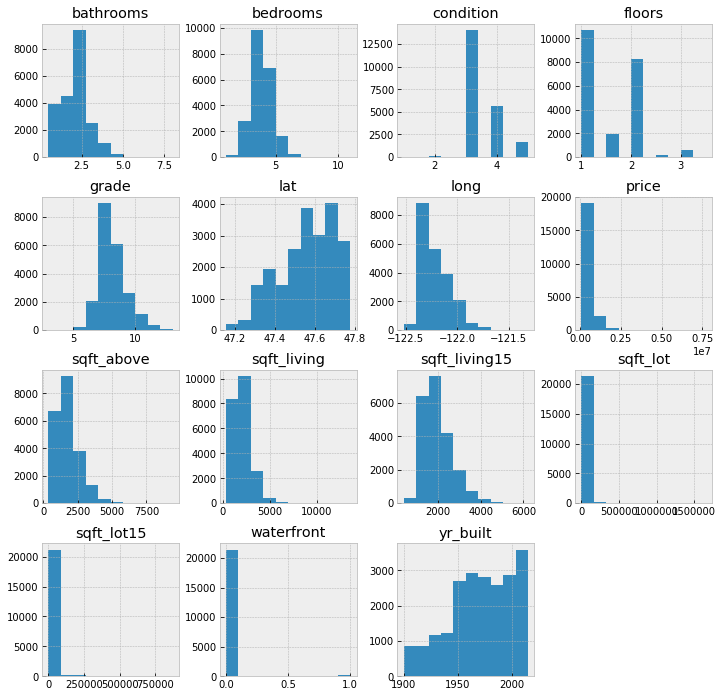

In [457]:
# lets see what these features look like.
kc_df.hist(figsize = (12,12));

Observations - Some data looks skewed, confirming earlier observations. Some data looks categorical,
once data is cleaned I will look at linear relationships to see if I should treat as categorical or continuous

In [11]:
#dropping the row that has the 33 bedroom outier

kc_df = kc_df[kc_df.bedrooms != 33]
kc_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159600e+04,21596.000000,21596.000000,21596.000000,2.159600e+04,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000
mean,5.402920e+05,3.371828,2.115843,2080.343165,1.509983e+04,1.494119,0.006761,3.409752,7.657946,1788.631506,1971.000787,98077.950685,47.560087,-122.213977,1986.650722,12758.656649
std,3.673760e+05,0.904114,0.768998,918.122038,4.141355e+04,0.539685,0.081946,0.650471,1.173218,827.763251,29.375460,53.514040,0.138552,0.140725,685.231768,27275.018316
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.619000e+03,1.500000,0.000000,3.000000,7.000000,1560.000000,1975.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068550e+04,2.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,9410.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


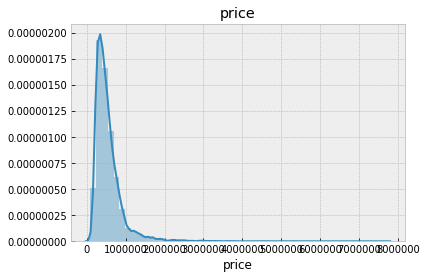

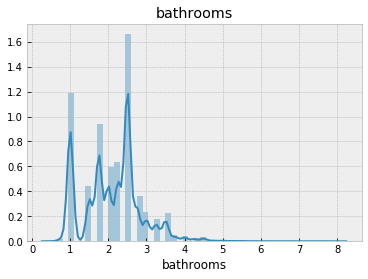

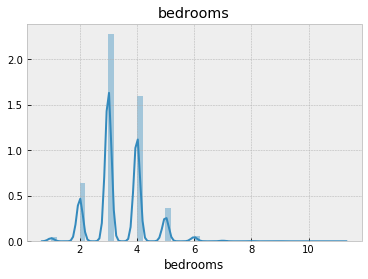

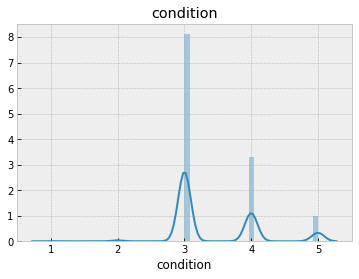

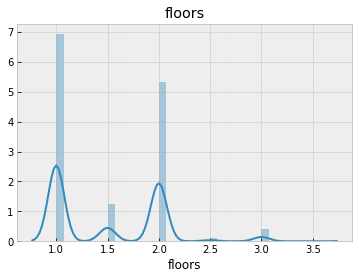

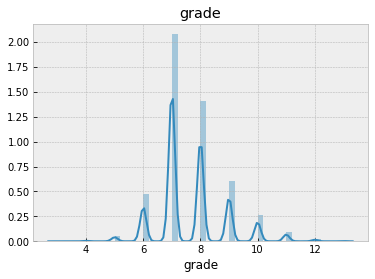

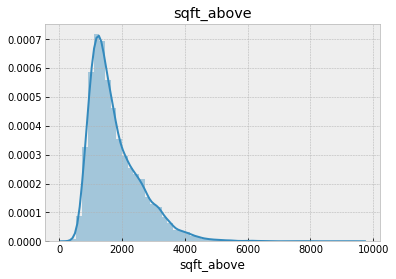

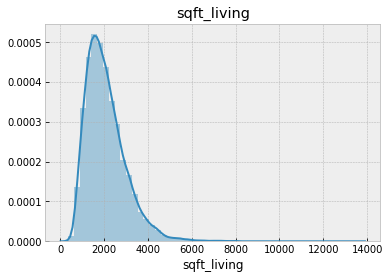

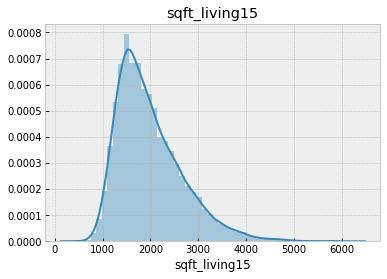

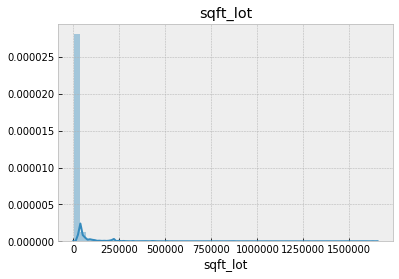

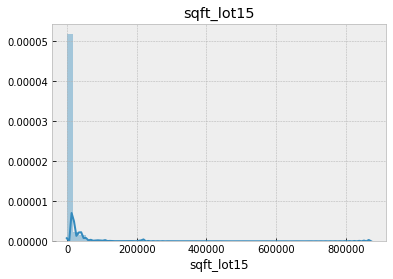

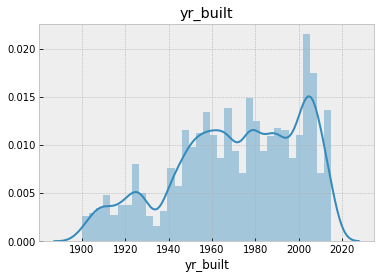

In [42]:
# lets take a closer look at continuous variables
column_list = ['price', 'bathrooms', 'bedrooms', 'condition', 'floors', 'grade', 'sqft_above', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15','yr_built']
for col in column_list:
    sns.distplot(kc_df[col])
    plt.title(col)
    plt.show();

I think some of the variables are too skewed to use as-is. Some also have a lot of "peakedness". Some look 
categorical. I will try log-transformations and look at scatterplots to check for linear relationships with the target.

In [89]:
# Making a DF of cleaned features that I will normalize, scale, and then model.
# Dropping zipcode, lat, and long for now, these will have to be one-hot encoded if used.  
# Will explore later on and add back to model.

data_pred= kc_df.drop([ 'zipcode', 'lat', 'long'], axis =1)
data_pred.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,1955,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,1951,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,1933,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,1965,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,1987,1800,7503


### Correlation and Collinearity

### How well are the variables correlated with the target and is there any collinearity to be worried about?

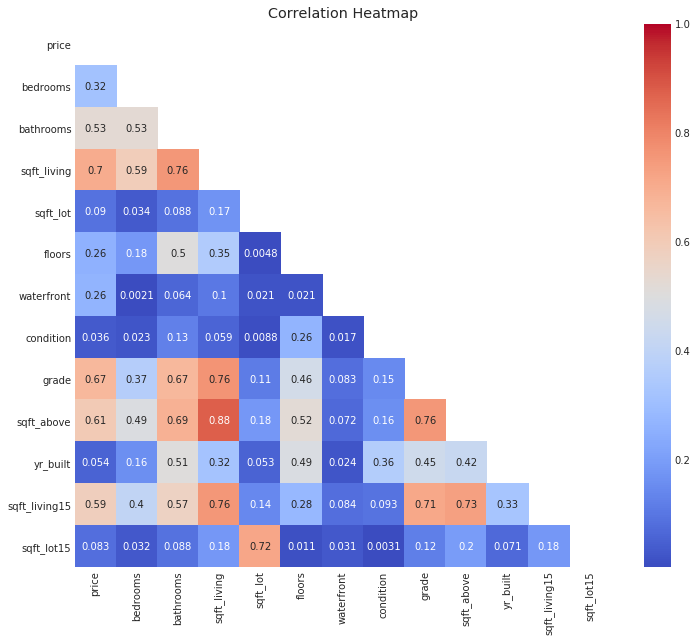

In [90]:
# plotting heatmap of variables for correlation and collinearity
plt.figure(figsize=(12,10))
corr = abs(data_pred.corr())
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap');

Target variable is 'price'. The features that are most highly correlated with 'price' are:  
'sqft_living', 'grade', and 'sqft_above'. The least correlated:  'condition', 'yr_built', and 'sqft_lot15'.

Dropping 'sqft_above' because it is highly colinear with 'sqft_living', and will bias my model.  
It also seems like they are measuring almost the same thing.  
I am changing 'waterfront's type to category.


In [91]:
data_pred = data_pred.drop(['sqft_above'], axis=1)

In [92]:
data_pred['waterfront'] = data_pred.waterfront.astype('category')

### Scaling and Normalization

In [416]:
# Looking at how skewed the data is.
data_pred.skew()

price             4.023329
bedrooms          0.551382
bathrooms         0.519644
sqft_living       1.473143
sqft_lot         13.072315
floors            0.614427
waterfront       12.039300
condition         1.036107
grade             0.788166
yr_built         -0.469549
sqft_living15     1.106828
sqft_lot15        9.524159
dtype: float64

I am log-transforming the obviously skewed data. (-1 < Skew < 1)  
(Except 'waterfront' because it is now categorical.)

In [93]:
# updating my exploration df with transformed variables
data_pred["sqft_living"] = np.log(data_pred["sqft_living"])
data_pred["sqft_lot"] = np.log(data_pred["sqft_lot"])
data_pred["sqft_lot15"] = np.log(data_pred["sqft_lot15"])
data_pred["price"] = np.log(data_pred["price"])
data_pred.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built,sqft_living15,sqft_lot15
0,12.309982,3,1.00,7.073270,8.639411,1.0,0.0,3,7,1955,1340,8.639411
1,13.195614,3,2.25,7.851661,8.887653,2.0,0.0,3,7,1951,1690,8.941022
2,12.100712,2,1.00,6.646391,9.210340,1.0,0.0,3,6,1933,2720,8.994917
3,13.311329,4,3.00,7.580700,8.517193,1.0,0.0,5,7,1965,1360,8.517193
4,13.142166,3,2.00,7.426549,8.997147,1.0,0.0,3,8,1987,1800,8.923058


### Did the log-transfomations improve distributions?

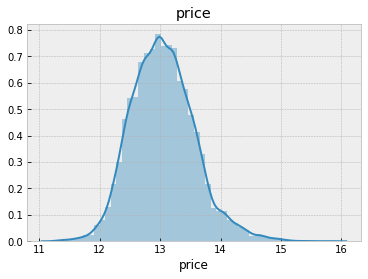

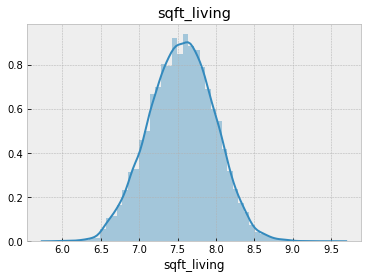

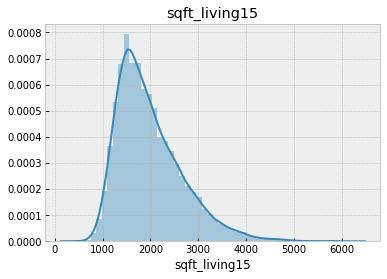

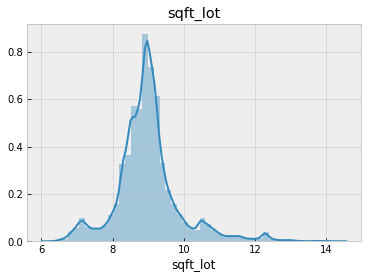

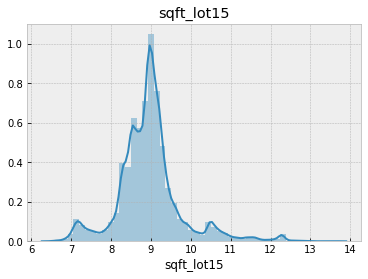

In [37]:
# plots of transformed variables to see if improved by log-transformation.
column_list = ['price', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']
for col in column_list:
    sns.distplot(data_pred[col])
    plt.title(col)
    plt.show();

These features now have a more normal distibution. A bit "peaky" but I think good enough to move on to checking visually for linear relationships with the target.

### Do the features have a linear relationships with the target?

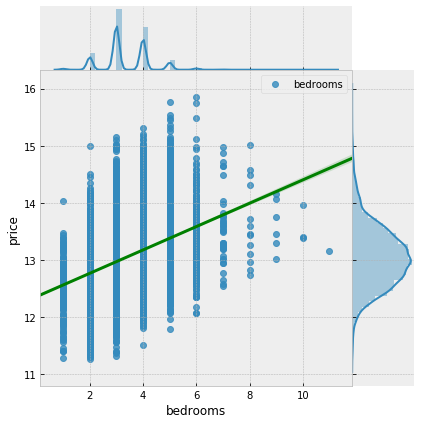

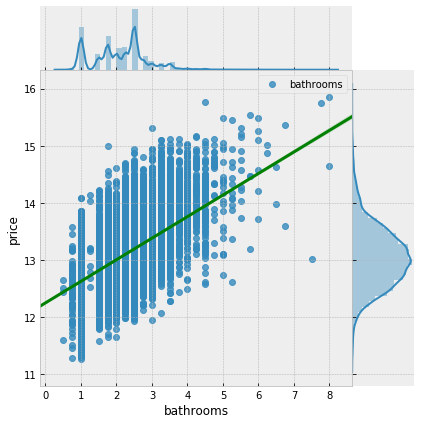

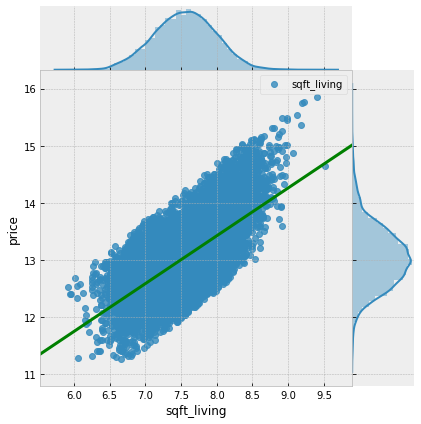

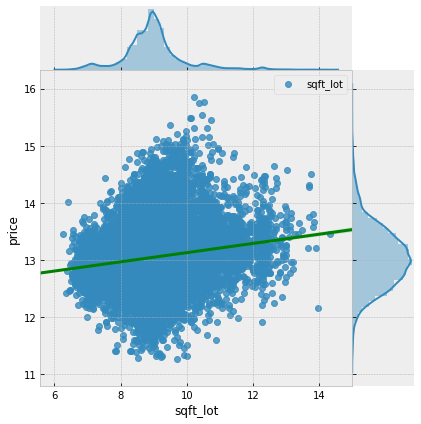

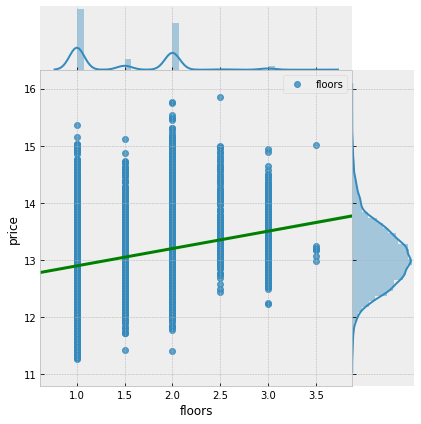

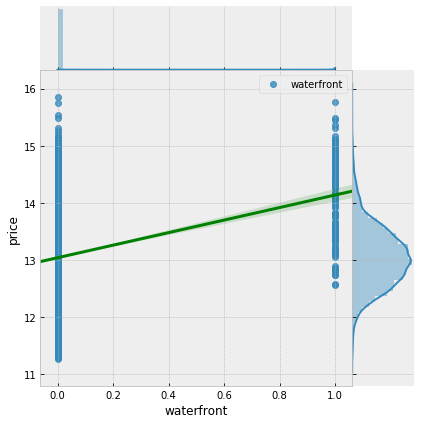

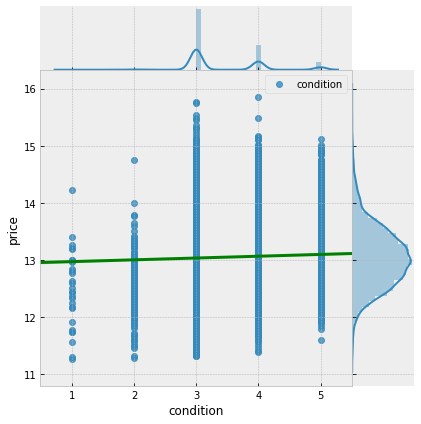

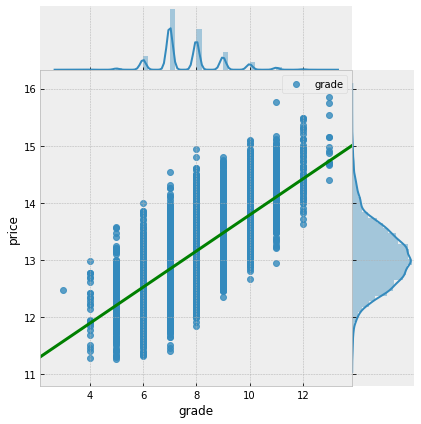

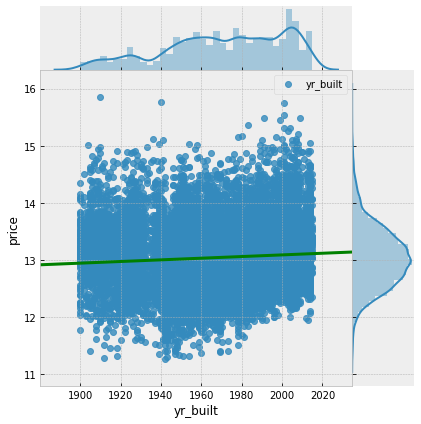

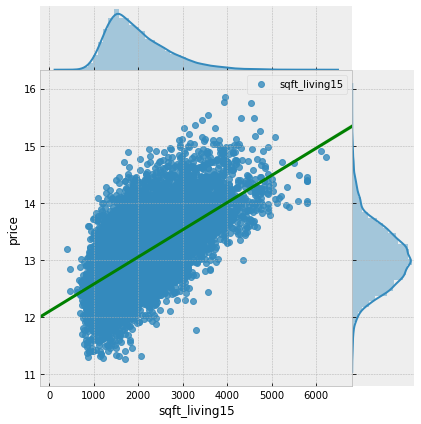

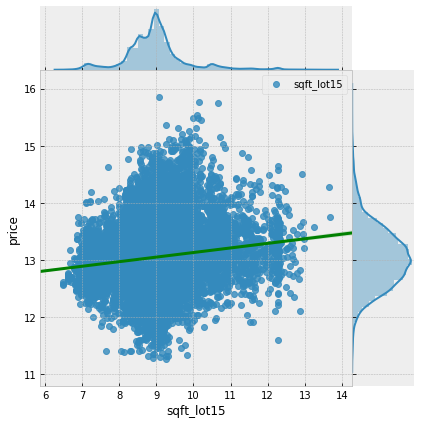

In [38]:
# With jointplots we can look at the transformed histograms and KDE as well as linear relationships with target.
for column in data_pred.drop('price', axis=1):
    sns.jointplot(x=column, y='price',
                  data=data_pred, 
                  kind='reg',
                  space=0.0,
                  label=column,
                  joint_kws={'line_kws':{'color':'green'}})
    #plt.title("Price vs " + column)
    plt.legend()
    plt.show()

Looking at the histograms with density estimates, we can see that data that was log-transformed now have a less skewed distribution. With the scatterplots with the best-fit line drawn, I am satisfied that the independent variables have a good enough linear relationship with the target as to continue with modeling. The best linear relationships are with sqft_living and grade.  I am going to treat the discrete data variables as continuous data (except for waterfront which is categorical) as they appear to have a linear relationship with the target.

### MinMax scaling the data

In [19]:
# scaling the data. I am chosing to min-max scale the data so everything will be on the same scale of 0-1.  


data_minMax = data_pred.drop(['waterfront', 'price'], axis=1)

for column in data_minMax:
    data_minMax[column] = (data_minMax[column]-min(data_minMax[column]))/(max(data_minMax[column])-min(data_minMax[column]))

data_df = pd.concat([data_minMax, data_pred[['price','waterfront']]], axis=1)    
data_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,sqft_lot15,price,waterfront
0,0.2,0.066667,0.322166,0.295858,0.0,0.5,0.4,0.478261,0.161934,0.300162,12.309982,0.0
1,0.2,0.233333,0.538392,0.326644,0.4,0.5,0.4,0.443478,0.222165,0.342058,13.195614,0.0
2,0.1,0.066667,0.203585,0.366664,0.0,0.5,0.3,0.286957,0.399415,0.349544,12.100712,0.0
3,0.3,0.333333,0.463123,0.280700,0.0,1.0,0.4,0.565217,0.165376,0.283185,13.311329,0.0
4,0.2,0.200000,0.420302,0.340224,0.0,0.5,0.5,0.756522,0.241094,0.339562,13.142166,0.0


In [96]:
# sanity check

data_df.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,sqft_living15,sqft_lot15,price
count,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000
mean,0.237183,0.215446,0.454797,0.339315,0.197648,0.602438,0.465795,0.617398,0.273215,0.344802,13.048196
std,0.090411,0.102533,0.117836,0.111877,0.215874,0.162618,0.117322,0.255439,0.117920,0.112878,0.526562
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.264464
25%,0.200000,0.166667,0.375546,0.281688,0.000000,0.500000,0.400000,0.443478,0.187747,0.285936,12.682307
50%,0.200000,0.233333,0.455945,0.332938,0.200000,0.500000,0.400000,0.652174,0.247978,0.341712,13.017003
75%,0.300000,0.266667,0.536222,0.374886,0.400000,0.750000,0.500000,0.843478,0.337463,0.380616,13.377006
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.856731


In [20]:
# setting waterfront as type category.
data_df['waterfront'] = data_df.waterfront.astype('category')

In [429]:
#making sure everything looks right
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 12 columns):
bedrooms         21596 non-null float64
bathrooms        21596 non-null float64
sqft_living      21596 non-null float64
sqft_lot         21596 non-null float64
floors           21596 non-null float64
condition        21596 non-null float64
grade            21596 non-null float64
yr_built         21596 non-null float64
sqft_living15    21596 non-null float64
sqft_lot15       21596 non-null float64
price            21596 non-null float64
waterfront       21596 non-null category
dtypes: category(1), float64(11)
memory usage: 2.0 MB


# Modeling the Data

### Running Ordinary Ordinary Squares regression experiments in Statsmodels
I am using StatsModels because the summay contains a lot of information and the layout is easy to read.

In [25]:
outcome = 'price'
predictors = data_df.drop(['price'], axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + "~" + pred_sum
model = ols(formula= formula, data=data_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     3767.
Date:                Sat, 30 Mar 2019   Prob (F-statistic):               0.00
Time:                        23:05:00   Log-Likelihood:                -5221.1
No. Observations:               21596   AIC:                         1.047e+04
Df Residuals:                   21584   BIC:                         1.056e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            11.7254      0.015    766.698      0.000      11.695      11.755
waterfront[T.1.0]     0.5532      0.026     21.375      0.000       0.503       0.604
bedrooms             -0.4225      0.031    -13.482      0.000      -0.484      -0.361
bathrooms             0.6303      0.036     17.288      0.000       0.559       0.702
sqft_living           1.2824      0.040     31.807      0.000       1.203       1.361
sqft_lot             -0.1437      0.049     -2.956      0.003      -0.239      -0.048
floors                0.1158      0.013      8.900      0.000       0.090       0.141
condition             0.1716      0.014     12.188      0.000       0.144       0.199
grade                 2.0690      0.031     65.887      0.000       2.007       2.131
yr_built             -0.6877      0.011    -63.881      0.000      -0.709      -0.667
sqft_living15         0.7683      0.030     25.985      0.000       0.710       0.826
sqft_lot15           -0.3664      0.048     -7.646      0.000      -0.460      -0.272
==============================================================================
Omnibus:                       48.465   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.757
Skew:                          -0.056   Prob(JB):                     4.74e-13
Kurtosis:                       3.225   Cond. No.                         51.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

An adjusted R-squared of 0.657 is pretty good, considering I still have data to add to the model.  
All p-values are better than 0.05.
Skew shows not much tailing. A kurtosis of 3.225 is close to expected value of 3 for normal distibution.  
However, the high JB score tells me that the data may not be normally distributed. 
'bedrooms' , sqft_lot', 'yr_built', and 'sqft_lot15' have a negative coefficient. something to keep an eye on.

### Are the residuals consistent with a normal distribution?

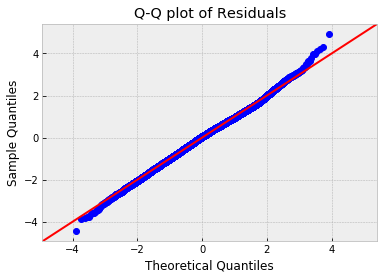

In [28]:
# q-q plot to visualize the residuals

residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
plt.title("Q-Q plot of Residuals");


The Q-Q plot shows some peakyness or tailing perhaps, but for the most part seems close to a normal distibution. Real life data  
won't be perfect!

In [475]:
# Checking model performance with cross-validaton
linreg = LinearRegression()

X = data_df.drop(['price'], axis=1)
y = data_df.price

cv_results = cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error")
cv_results

array([-0.09485161, -0.09953494, -0.09634111, -0.09786468, -0.09079897,
       -0.09538301, -0.09304397, -0.10168181, -0.09753282, -0.09143151])

In [476]:
np.mean(cv_results)

-0.09584644256982353

Results look pretty consistent. A good sign.

In [466]:
# Running recursive feature elimination to look for candidate variables to drop to see if I can improve model.

predictors = data_df.drop(['price', 'waterfront'], axis=1)

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 1)
selector = selector.fit(predictors, data_df["price"])
list(zip(predictors.columns,selector.ranking_))

[('bedrooms', 7),
 ('bathrooms', 3),
 ('sqft_living', 2),
 ('sqft_lot', 8),
 ('floors', 10),
 ('condition', 9),
 ('grade', 1),
 ('yr_built', 4),
 ('sqft_living15', 5),
 ('sqft_lot15', 6)]

In [39]:
# dropping floors (the worst ranked) to see if it improves model. 

data_dr = data_df.drop(['floors'], axis=1)

In [40]:
# no floors
outcome = 'price'
predictors1 = data_dr.drop(['price'], axis=1)
pred_sum1 = "+".join(predictors1.columns)
formula1 = outcome + "~" + pred_sum1
model1 = ols(formula= formula1, data=data_dr).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     4121.
Date:                Sun, 31 Mar 2019   Prob (F-statistic):               0.00
Time:                        14:09:50   Log-Likelihood:                -5260.7
No. Observations:               21596   AIC:                         1.054e+04
Df Residuals:                   21585   BIC:                         1.063e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            11.7295      0.015    765.928      0.000      11.700      11.760
waterfront[T.1.0]     0.5575      0.026     21.506      0.000       0.507       0.608
bedrooms             -0.4345      0.031    -13.853      0.000      -0.496      -0.373
bathrooms             0.6855      0.036     19.048      0.000       0.615       0.756
sqft_living           1.3036      0.040     32.330      0.000       1.225       1.383
sqft_lot             -0.1902      0.048     -3.928      0.000      -0.285      -0.095
condition             0.1570      0.014     11.206      0.000       0.130       0.184
grade                 2.1125      0.031     67.984      0.000       2.052       2.173
yr_built             -0.6655      0.010    -63.435      0.000      -0.686      -0.645
sqft_living15         0.7643      0.030     25.805      0.000       0.706       0.822
sqft_lot15           -0.3904      0.048     -8.145      0.000      -0.484      -0.296
==============================================================================
Omnibus:                       49.190   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.684
Skew:                          -0.063   Prob(JB):                     4.91e-13
Kurtosis:                       3.217   Cond. No.                         51.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
linreg = LinearRegression()

X = data_dr.drop(['price'], axis=1)
y = data_dr.price

cv_results1 = cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error")
np.mean(cv_results1)

-0.09624959494257829

Dropping that variable didn't improve my model (actually slightly hurt it).

In [439]:
# seeing if model improves when the categorical variable 'waterfront' is removed.  It is mostly 0's.
data_dr_water = data_df.drop('waterfront', axis=1)

outcome = 'price'
predictors2 = data_dr_water.drop(['price'], axis=1)
pred_sum2 = "+".join(predictors2.columns)
formula2 = outcome + "~" + pred_sum2
model2 = ols(formula= formula, data=data_dr_water).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     4013.
Date:                Sun, 17 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:57:06   Log-Likelihood:                -5447.3
No. Observations:               21596   AIC:                         1.092e+04
Df Residuals:                   21585   BIC:                         1.100e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        11.7157      0.015    758.434      0.000      11.685      11.746
bedrooms         -0.4667      0.032    -14.769      0.000      -0.529      -0.405
bathrooms         0.6622      0.037     17.991      0.000       0.590       0.734
sqft_living       1.2975      0.041     31.853      0.000       1.218       1.377
sqft_lot         -0.1571      0.049     -3.197      0.001      -0.253      -0.061
floors            0.1209      0.013      9.204      0.000       0.095       0.147
condition         0.1724      0.014     12.118      0.000       0.145       0.200
grade             2.0878      0.032     65.822      0.000       2.026       2.150
yr_built         -0.7056      0.011    -65.053      0.000      -0.727      -0.684
sqft_living15     0.7740      0.030     25.906      0.000       0.715       0.833
sqft_lot15       -0.3259      0.048     -6.737      0.000      -0.421      -0.231
==============================================================================
Omnibus:                       50.905   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.257
Skew:                          -0.015   Prob(JB):                     1.11e-14
Kurtosis:                       3.266   Cond. No.                         51.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [477]:
linreg = LinearRegression()

X = data_dr.drop(['price','waterfront'], axis=1)
y = data_dr.price

cv_results2 = cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error")
np.mean(cv_results2)

-0.09884575111889718

Removing waterfront hurts my model.  I will keep the original model and move on with examining lat, long, and zipcode.

## Categorical Variables

### Location, location, location

I have three dependent variables left to examine; lat, long, and zipcode.  These all are geographical data indicating where the houses are located. I will look at each one to see how best to add to my model.

In [206]:
# How many unique values?
kc_df.zipcode.nunique()

70

In [204]:
kc_df.lat.nunique()

5033

In [207]:
kc_df.long.nunique()

751

### Does location affect price?

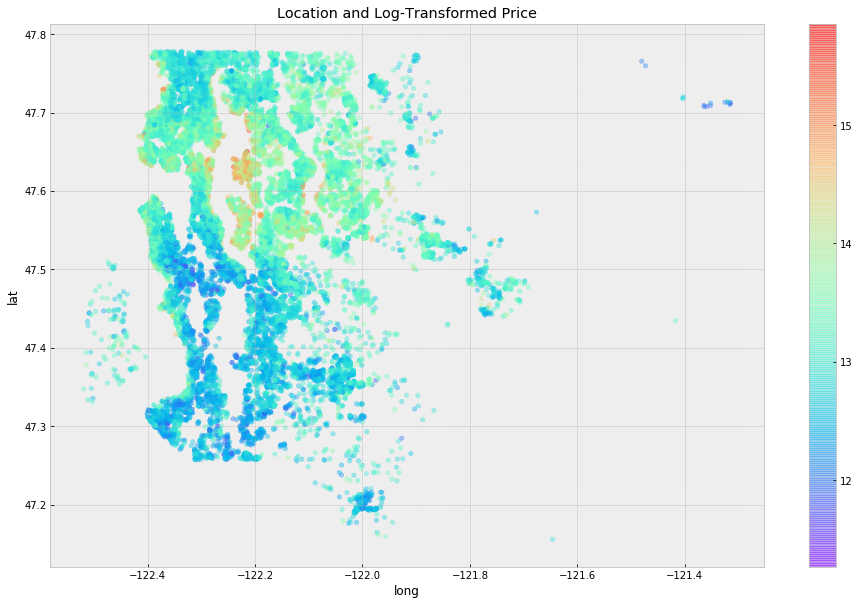

In [485]:
# Scatter plot of long and lat color mapped to log-transformed price data.

kc_df.plot(kind="scatter", x="long", y="lat", alpha=0.4, figsize=(16,10),
    c=data_pred["price"], cmap="rainbow", colorbar=True,
    sharex=False)
plt.title("Location and Log-Transformed Price")
plt.show()


Obviously location affects price! You can see how the house prices are higher in certain areas.     

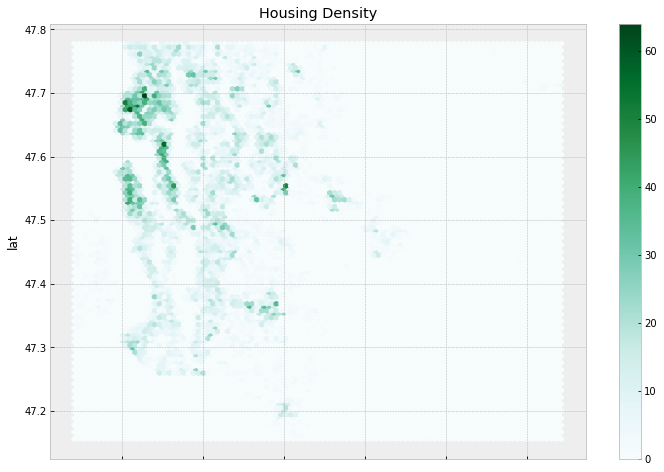

In [61]:
# Looking at a hexbin plot for density of locations (just curious)
kc_df.plot.hexbin(x='long', y='lat', figsize=(12,8))
plt.title("Housing Density");

Moving on to look at zipcode

In [51]:
kc_df['zipcode'] = kc_df.zipcode.astype('int')

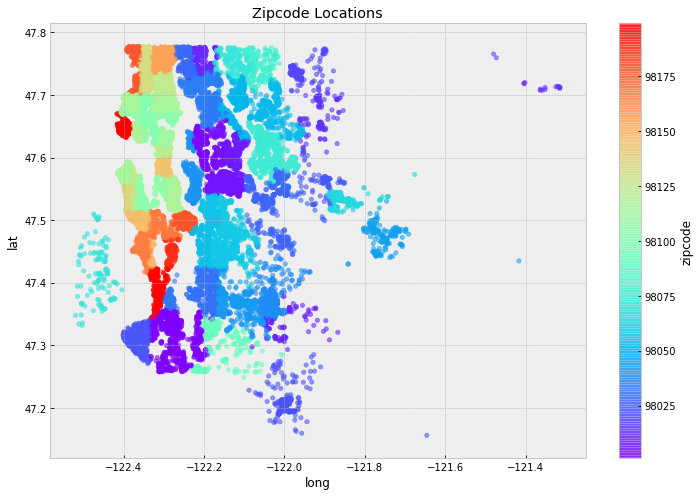

In [52]:
kc_df.plot(kind="scatter", x="long", y="lat", alpha=0.6, figsize=(12,8),
    c='zipcode', cmap="rainbow", colorbar=True,
    sharex=False)
plt.title("Zipcode Locations");

I don't see any way to easily group zipcodes. I will do some further exploration, but will probably end up one-hot encoding the feature into categories.  

The lat and long gave me a nice graph that showed the importance of location on price, but I don't see a way to easily use in my linear regression model. I am thinking using lat and long and zipcode would be redundant anyway, so I will use zipcode in my model.

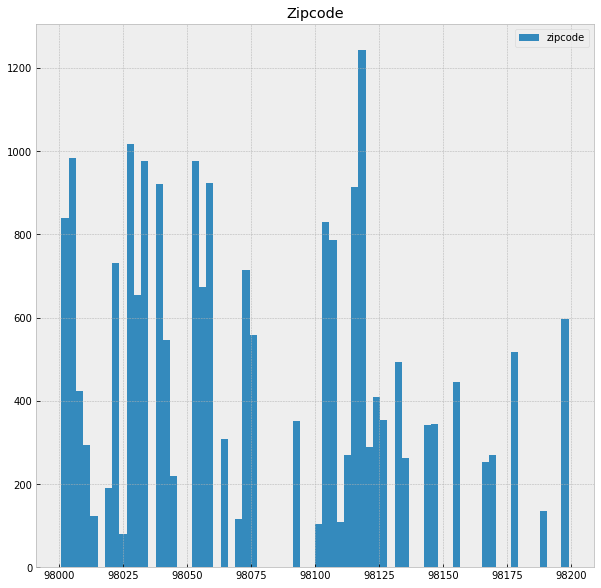

In [53]:
# looking at Zipcode
kc_df.zipcode.hist(bins = 70, figsize=(10,10), label='zipcode')
plt.legend()
plt.title('Zipcode');

Not normally distributed at all. Defininitely categorical.

In [356]:
kc_df['zipcode'].value_counts();

98103    601
98038    589
98115    583
98052    574
98117    553
98042    547
98034    545
98118    507
98023    499
98006    498
98133    493
98059    468
98058    455
98155    446
98074    441
98033    432
98027    412
98125    409
98056    406
98053    403
98001    361
98075    359
98126    354
98092    351
98144    343
98106    335
98116    330
98029    321
98199    317
98004    317
        ... 
98112    269
98168    269
98055    268
98107    266
98136    263
98178    262
98030    256
98177    255
98166    254
98022    233
98105    229
98045    220
98002    199
98077    198
98011    195
98019    190
98108    186
98119    184
98005    168
98007    141
98188    136
98032    125
98014    124
98070    117
98109    109
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [29]:
# One-hot encoding 'zipcode' variable and adding to my model.

kc_df['zipcode'] = kc_df.zipcode.astype('str')
zip_dummy = pd.get_dummies(kc_df.zipcode, prefix = 'ZC')

final_df = pd.concat([data_df, zip_dummy], axis=1)

In [442]:
# Checking data to see if everything is how I want it.
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 82 columns):
bedrooms         21596 non-null float64
bathrooms        21596 non-null float64
sqft_living      21596 non-null float64
sqft_lot         21596 non-null float64
floors           21596 non-null float64
condition        21596 non-null float64
grade            21596 non-null float64
yr_built         21596 non-null float64
sqft_living15    21596 non-null float64
sqft_lot15       21596 non-null float64
price            21596 non-null float64
waterfront       21596 non-null category
ZC_98001         21596 non-null uint8
ZC_98002         21596 non-null uint8
ZC_98003         21596 non-null uint8
ZC_98004         21596 non-null uint8
ZC_98005         21596 non-null uint8
ZC_98006         21596 non-null uint8
ZC_98007         21596 non-null uint8
ZC_98008         21596 non-null uint8
ZC_98010         21596 non-null uint8
ZC_98011         21596 non-null uint8
ZC_98014         21596 non-nul

In [30]:
# dropping one of the zipcode columns

final_df = final_df.drop('ZC_98004', axis =1)

In [31]:
# Modeling dataset with multivariate linear regression.
outcome = 'price'
predictors_fin = final_df.drop(['price'], axis=1)
pred_sum_fin = "+".join(predictors_fin.columns)
formula_fin = outcome + "~" + pred_sum_fin
model_fin = ols(formula= formula_fin, data=final_df).fit()
model_fin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     1900.
Date:                Sat, 30 Mar 2019   Prob (F-statistic):               0.00
Time:                        23:22:20   Log-Likelihood:                 5749.7
No. Observations:               21596   AIC:                        -1.134e+04
Df Residuals:                   21515   BIC:                        -1.069e+04
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.1556      0.016    775.067      0.000      12.125      12.186
waterfront[T.1.0]     0.6583      0.016     41.414      0.000       0.627       0.689
bedrooms             -0.1885      0.019     -9.805      0.000      -0.226      -0.151
bathrooms             0.3335      0.022     15.025      0.000       0.290       0.377
sqft_living           1.3788      0.024     56.282      0.000       1.331       1.427
sqft_lot              0.6374      0.030     21.233      0.000       0.579       0.696
floors                0.0325      0.008      3.955      0.000       0.016       0.049
condition             0.1875      0.009     21.423      0.000       0.170       0.205
grade                 1.0339      0.020     50.846      0.000       0.994       1.074
yr_built             -0.0830      0.008     -9.992      0.000      -0.099      -0.067
sqft_living15         0.5665      0.019     29.827      0.000       0.529       0.604
sqft_lot15           -0.1606      0.030     -5.417      0.000      -0.219      -0.102
ZC_98001             -1.1096      0.015    -76.305      0.000      -1.138      -1.081
ZC_98002             -1.1035      0.017    -64.573      0.000      -1.137      -1.070
ZC_98003             -1.0927      0.015    -71.045      0.000      -1.123      -1.063
ZC_98005             -0.4173      0.018    -23.519      0.000      -0.452      -0.383
ZC_98006             -0.4820      0.013    -36.050      0.000      -0.508      -0.456
ZC_98007             -0.4771      0.019    -25.294      0.000      -0.514      -0.440
ZC_98008             -0.4497      0.015    -29.402      0.000      -0.480      -0.420
ZC_98010             -0.8701      0.022    -40.265      0.000      -0.912      -0.828
ZC_98011             -0.6794      0.017    -39.961      0.000      -0.713      -0.646
ZC_98014             -0.8082      0.020    -40.051      0.000      -0.848      -0.769
ZC_98019             -0.7985      0.017    -46.039      0.000      -0.832      -0.764
ZC_98022             -1.0278      0.016    -62.777      0.000      -1.060      -0.996
ZC_98023             -1.1444      0.013    -84.799      0.000      -1.171      -1.118
ZC_98024             -0.6904      0.024    -29.229      0.000      -0.737      -0.644
ZC_98027             -0.6202      0.014    -44.335      0.000      -0.648      -0.593
ZC_98028             -0.7035      0.015    -45.945      0.000      -0.733      -0.673
ZC_98029             -0.5153      0.015    -34.582      0.000      -0.545      -0.486
ZC_98030             -1.0611      0.016    -67.117      0.000      -1.092      -1.030
ZC_98031             -1.0467      0.016    -67.396      0.000      -1.077      -1.016
ZC_98032             -1.1327      0.020    -57.270      0.000      -1.171      -1.094
ZC_98033             -0.3207      0.014    -23.236      0.000      -0.348

Adding zipcode to my model increased the adjusted R-squared from 0.657 to 0.876.  So zipcode can explain 21.9% of the 
variance in the price. That's a lot!  

The adjusted r-squared of 0.876 in my final model is pretty good. All the p-values are less than 0.05. The biggest issue I see is the negative coefficients for 'bedrooms' and 'yr_built'. I think that indicates interactions between features that may not be obvious. I am keeping them in, using the p-values as justification.

## Model Validation

In [32]:
# K-folds cross validation of my final model using negative mean squared error
linreg = LinearRegression()

X = final_df.drop(['price'], axis=1)
y = final_df.price

cv_results3 = cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error")
cv_results3

array([-0.03428675, -0.0370451 , -0.03566962, -0.0357842 , -0.03316145,
       -0.0357037 , -0.03419218, -0.03669121, -0.03534284, -0.0309256 ])

In [33]:
np.mean(cv_results3)

-0.03488026597319434

In [64]:
# Coefficient of variation of cross validation results
abs(np.std(cv_results3)/np.mean(cv_results3))*100

4.942280141700788

In [65]:
# Using r-squared
linreg = LinearRegression()

X = final_df.drop(['price'], axis=1)
y = final_df.price

cv_results4 = cross_val_score(linreg, X, y, cv=10)
cv_results4

array([0.8759028 , 0.87644342, 0.86667069, 0.8741245 , 0.8675731 ,
       0.87361936, 0.87786505, 0.87663803, 0.87589277, 0.86835936])

Adding zipcode also improved my cross validation score. And the results showed little variation.

In [47]:
# Train-test-split as another check on my model's performance.
y = final_df[["price"]]
X = final_df.drop(["price"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.03466335236355768
Test Mean Squarred Error: 0.03337063914965873


The test MSE and train MSE are very similar, giving me confidence the model didn't overfit or underfit the model.

# Interpret Results

### Final Model Summary

For the final model used 12 independent variables (80 if you count the 69 dummy variables used for zipcode separately)  and 21596 data points. The OLS regression model has an adjusted R-squared of 0.876. This gives me a fairly high level of confidence in my model to accurately predict housing prices. The remaining 0.124 could be influence of factors such as features that weren't included in the data set, sampling error, seasonal market fluctuations, or less tangeable factors like a seller's skills or bidding wars that bump up the price. The features that have the most effect on the sales price seem to be zipcode, grade, sqft_living, and bathrooms.  

The p-values of all my independent variables are less than 0.05 which shows that they all have greater than 95% chance that the coeficient isn't zero. Another factor that gives me confidence in the performance of my model is the k-folds cross validation. I had little variation across the resulting negative mean squared errors. (Average of -0.035 and a CV of 4.9%) I also performed a train-test-split validation which produced similar results. (Train: 0.035 and Test: 0.033) This shows I haven't over fit or under fit the model.

#### Interpreting Coefficients
Here is a closer look at some of the coefficients:  
The min-max scaled and log-transformed independent variable 'sqft_living' has a coefficient of 1.3788. For a 1% increase/decrease in 'sqft_living' we expect about a 1.3788% increase/decrease in sales price with everything else remaining unchanged.

The categorical feature 'waterfront'has a coefficient of 0.6583. So if the property has a view of the water it increases the price about 93% with everything else remaining unchanged.

The min-max scaled feature 'grade' has a coefficient of 1.0339. If, for example, the grade is 4. Min-max scaled would make it 0.1. Then we would expect about a 10.8% increase in price. If the grade is 8, min-max scaled makes it 0.5. Then we would expect about a 67.7% increase in the sales price with everything else remaining unchangd.





In [94]:
# code to transform and scale variables. just for my information.
bedroom = (4-min(data_pred['bedrooms']))/(max(data_pred['bedrooms'])-min(data_pred['bedrooms']))
bathroom = (3-min(data_pred['bathrooms']))/(max(data_pred['bathrooms'])-min(data_pred['bathrooms']))
sqft_living = ((np.log(1960))-min(data_pred['sqft_living']))/(max(data_pred['sqft_living'])-min(data_pred['sqft_living']))
sqft_lot = ((np.log(5000))-min(data_pred['sqft_lot']))/(max(data_pred['sqft_lot'])-min(data_pred['sqft_lot']))
floor = (1-min(data_pred['floors']))/(max(data_pred['floors'])-min(data_pred['floors']))
waterfront = 0
condition = (5-min(data_pred['condition']))/(max(data_pred['condition'])-min(data_pred['condition']))
grade = (7-min(data_pred['grade']))/(max(data_pred['grade'])-min(data_pred['grade']))
year = (1965-min(data_pred['yr_built']))/(max(data_pred['yr_built'])-min(data_pred['yr_built']))
living15 = ((np.log(1360))-min(data_pred['sqft_living15']))/(max(data_pred['sqft_living15'])-min(data_pred['sqft_living15']))
lot15 = ((np.log(5000))-min(data_pred['sqft_lot15']))/(max(data_pred['sqft_lot15'])-min(data_pred['sqft_lot15']))
# zip = 98125

price = 12.1556 + (bedroom*(-0.1885))+(bathroom*0.3335)+(sqft_living*1.3788)+(sqft_lot*0.6374)+(floor*0.0325)+(waterfront*0.6583)+(condition*0.1875)+(grade*1.0339)+(year*(-0.083))+(living15*0.5665)+(lot15*(-0.1606))+(-0.3872)

In [76]:
(8-min(data_pred['grade']))/(max(data_pred['grade'])-min(data_pred['grade']))

0.5